In [4]:
Trabajo Practico 2

SyntaxError: invalid syntax (<ipython-input-4-cc03ac5842df>, line 1)

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from  collections  import defaultdict
from scipy import optimize
import os
from lectura import ldata

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [ ]:
# Red de interacciones binarias(yeast_Y2H.txt)
# Red de copertenecia o complejos proteícos(yeast_AP-MS.txt)
# Red obtenida de literatura: Yeast Interactome Database(yeast_LIT.txt)

In [5]:
# El directorio que vamos a usar en cada lectura de datos de ahora en mas
directorio = os.path.dirname(os.path.realpath("yeast_AP-MS.txt"))

In [6]:
fnMS = os.path.join(directorio,'tc02Data/yeast_AP-MS.txt')
fnLIT = os.path.join(directorio,'tc02Data/yeast_LIT.txt')
fnY2H = os.path.join(directorio,'tc02Data/yeast_Y2H.txt')
fnLIT_reg = os.path.join(directorio,'tc02Data/yeast_LIT_Reguly.txt')

# Lectura de datos
datosapms=ldata(fnMS)
datoslit=ldata(fnLIT)
datosy2h=ldata(fnY2H)
datoslit_reg=ldata(fnLIT_reg)
datoslit_reg=[row[0:2] for row in datoslit_reg][1:]


In [7]:
G1 = nx.Graph()
G2 = nx.Graph()
G3 = nx.Graph()
G4 = nx.Graph()

G1.add_edges_from(datosapms)
G2.add_edges_from(datoslit)
G3.add_edges_from(datosy2h)
G4.add_edges_from(datoslit_reg)



In [8]:
# Características de las redes

# Numero total de nodos
N = [G1.number_of_nodes(),G2.number_of_nodes(),G3.number_of_nodes(),G4.number_of_nodes()]

# Numero total de enlaces
L = [G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges(),G4.number_of_edges()]

# Grado medio
kmean = [np.mean(list(dict(G1.degree).values())),np.mean(list(dict(G2.degree).values())),
         np.mean(list(dict(G3.degree).values())),
         np.mean(list(dict(G4.degree).values()))]

# Coeficiente de clustering local
clusteringlocal = [nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3),nx.average_clustering(G4)]


In [9]:
# Tabla con las caraterísticas de las redes
info= pd.DataFrame({"ID":['apms','YID_lit','y2h','lit_reg'],"nodos":N,"enlaces":L,"kmean":kmean,
                    "clusteringlocal":clusteringlocal})

In [49]:
info

,ID,clusteringlocal,enlaces,kmean,nodos
0,apms,0.554636,9070,11.183724,1622
1,YID_lit,0.292492,2925,3.808594,1536
2,y2h,0.046194,2930,2.903865,2018
3,lit_reg,0.261134,11858,7.171454,3307


In [10]:
def overlap(red1,red2):
    cant=0
    for edge in red1.edges():
        if edge in red2.edges():
            cant+=1
            
    return cant/red1.number_of_edges()

In [51]:
overlap(G1,G2)

0.14310915104740904

In [11]:
nombres=['apms','YID_lit','y2h','lit_reg']
grafos=[G1,G2,G3,G4]
columna=[0]*4
for j in np.arange(4):
    columna[j]=[0,0,0,0]
    for i in np.arange(4):
        if i==j:
            columna[j][i]=nombres[i]
        else:
            columna[j][i]=overlap(grafos[i],grafos[j])
            
tabla2=pd.DataFrame(columna)

In [142]:
tabla2

,0,1,2,3
0,apms,0.443761,0.0887372,0.212515
1,0.143109,YID_lit,0.0887372,0.241187
2,0.0286659,0.0888889,y2h,0.0403947
3,0.277839,0.977778,0.163481,lit_reg


In [12]:
fnessential = os.path.join(directorio,'tc02Data/Essential_ORFs_paperHe.txt')
essential=ldata(fnessential)
essential=[row[1] for row in essential[2:-4]]

In [13]:
def essentialhubs(grafo,essential):
    Nodos=sorted(grafo.degree, key=lambda x: x[1], reverse=True)
    CantidadHubs=np.arange(len(Nodos)+1)
    CantidadEssential=[0]
    PorcEssential=[0]
    contador=1
    for nodo in Nodos:
        if nodo[0] in essential:
            CantidadEssential.append(CantidadEssential[-1]+1)
        else:
            CantidadEssential.append(CantidadEssential[-1])
        PorcEssential.append(CantidadEssential[-1]/CantidadHubs[contador])
        #print(CantidadHubs[contador],contador)
        contador+=1
    CantidadHubs=np.array(CantidadHubs)/len(Nodos)
    return [CantidadHubs,PorcEssential]

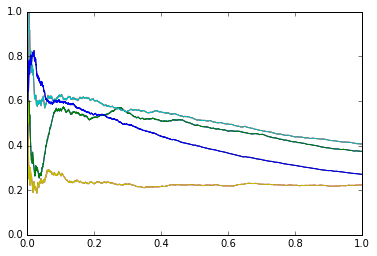

In [148]:
for i in np.arange(4):
    cantidad,esencial=essentialhubs(grafos[i],essential)
    plt.plot(cantidad,esencial)   
plt.show()

In [ ]:
#.degree
#eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight=None)
#subgraph_centrality(G)
#betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)
#current_flow_closeness_centrality(G, weight='weight', dtype=<type 'float'>, solver='lu')
#len(max(nx.connected_component_subgraphs(G1), key=len).nodes())

In [18]:
import random

In [54]:
def vulnerability(Grafo,essential):
    randomlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)/2:
            randomlist.append(len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño)
            fraccion.append(i/tamaño)
            nodo=random.choice(list(G.nodes()))
            G.remove_node(nodo)
            i+=1
    return fraccion,randomlist

In [127]:
def vulnerabilitygrado(Grafo,essential):
    gradolist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
#    Nodos=sorted(G.degree, key=lambda x: x[1], reverse=True)
    while len(G)>len(Grafo)/2:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            gradolist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            nodo=max(componente.degree)
            G.remove_node(nodo[0])
            i+=1
    return fraccion,gradolist

In [74]:
def vulnerabilityautovec(Grafo,essential):
    autoveclist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    Nodos=sorted(nx.eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight=None), key=lambda x: x[1], reverse=True)
    for nodo in Nodos:
            autoveclist.append(len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño)
            fraccion.append(i/tamaño)
            G.remove_node(nodo)
            i+=1
    return fraccion,autoveclist

In [76]:
def vulnerabilitysubgraph(Grafo,essential):
    subgraphlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    Nodos=sorted(nx.subgraph_centrality(G), key=lambda x: x[1], reverse=True)
    for nodo in Nodos:
            subgraphlist.append(len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño)
            fraccion.append(i/tamaño)
            G.remove_node(nodo)
            i+=1
    return fraccion,subgraphlist

In [79]:
def vulnerabilitybetweeness(Grafo,essential):
    betweenesslist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    Nodos=sorted(nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None), key=lambda x: x[1], reverse=True)
    for nodo in Nodos:
            betweenesslist.append(len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño)
            fraccion.append(i/tamaño)
            G.remove_node(nodo)
            i+=1
    return fraccion,betweenesslist

In [88]:
def vulnerabilityflow(Grafo,essential):
    flowlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    Nodos=sorted(nx.current_flow_closeness_centrality(max(nx.connected_component_subgraphs(G), key=len), weight=None, solver='lu'), key=lambda x: x[1], reverse=True)
    for nodo in Nodos:
            flowlist.append(len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño)
            fraccion.append(i/tamaño)
            G.remove_node(nodo)
            i+=1
    return fraccion2,flowlist

In [122]:
def vulnerabilityessential(Grafo,essential):
    G=Grafo.copy()
    tamaño=len(list(Grafo.nodes()))
    for nodo in Grafo.nodes():
        if nodo in essential:
            G.remove_node(nodo)
            
    essential=len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño
    fraccion3=(len(Grafo)-len(G))/tamaño

    return fraccion3,essential,len(Grafo)-len(G)

In [121]:
len(G1)

1622

In [131]:
f,lc=vulnerability(G1,essential)

In [132]:
f2,vgrado=vulnerabilitygrado(G1,essential)

In [72]:
f3,lcautovec=vulnerabilityautovec(G1,essential)

In [77]:
f4,lcsubgraph=vulnerabilitysubgraph(G1,essential)

In [92]:
f5,lcbetweeness=vulnerabilitybetweeness(G1,essential)

In [93]:
f6,lcflow=vulnerabilityflow(G1,essential)

In [133]:
f7,lcessential,cant=vulnerabilityessential(G1,essential)

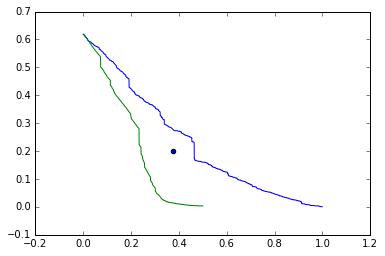

In [134]:
plt.plot(f,lc)
plt.plot(f2,vgrado)
#plt.plot(f,lcautovec)
#plt.plot(f,lcsubgraph)
#plt.plot(f,lcbetweeness)
#plt.plot(f,lcflow)
plt.scatter(f7,lcessential)
plt.show()

In [120]:
print(lc[cant],cant)
#f[cant]
#f3+f[cant]

0.08323057953144267 1015
